## **Подгружаем данные**

In [ ]:
%%capture
!gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
!gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
!gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
!gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
!gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

## **Подгружаем сгенерированные фичи**

In [ ]:

%%capture
!gdown 1TxOOpTVOG0z5OHqBOvfVnKlmOKRo62pp
!gdown 1gfzuNxnUNvmft8vukHFT9NOLiGXE5hJi

## **Устанавливаем доп. библиотеки и импортируем то, что нужно**

In [ ]:
%pip install catboost shap optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Other tools
import pickle
import random
import torch # (нужен для проверки использования GPU)
import glob
import os

from typing_extensions import Literal, Any, Callable, List
from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
import sklearn

from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import catboost
import optuna

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

## **Настроиваем переменные сессии**

In [ ]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 1
set_seed(SEED)

"""
1 - Добавление кастомных фичей
2 - Овер-сэмплинг с помощью SMOTE
"""
PIPELINE = 2

## **Считываем данные + переводим названия колонок в более читаемую форму**

In [ ]:
columns_descr = pd.read_excel("/content/описание.xlsx").set_index("колонка")
columns_dict = {key : value for key, value in zip(columns_descr.index, columns_descr["описание"])}

columns_descr.to_csv("columns_description.csv", index=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/описание.xlsx'

In [ ]:
X_train = pd.read_csv("/content/train_X.csv")
y_train = pd.read_csv("/content/train_y.csv")

train = X_train.merge(y_train, on=["contract_id", "report_date"], how="left")
test = pd.read_csv("/content/test2_X.csv")

In [ ]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v2.csv").drop(columns='contractor_distance_eccentricity')
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

In [ ]:
# adding contractor new graph features
graph_features = pd.read_csv("contractor_graph_features_v3.csv")
train = train.merge(graph_features, on="contractor_id", how="left")
test = test.merge(graph_features, on="contractor_id", how="left")

## **Теперь производим небольшой препроцессинг**

- список коррелирующих внутри одного контракта фичей
- список неизменяющихся внутри одного контракта фичей

In [ ]:
ts_features2drop = ['agg_cec_requests__g_contract__total_sum_accepted__all__sum__6W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__8W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__5W', 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 'agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME', 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__8W', 'agg_cec_requests__g_contract__request_id__all__count__4W', 'agg_cec_requests__g_contract__request_id__all__count__5W', 'agg_cec_requests__g_contract__request_id__all__count__7W', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxesSum__last__ALL_TIME', 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME', 'counteragent_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__request_id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M', 'agg_ks2__g_contract__id__all__count__ALL_TIME', 'agg_cec_requests__g_contract__request_id__all__count__12W', 'agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M', 'specialization_sum_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME', 'counteragent_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__4W', 'agg_workers__g_contract__fact_workers__all__mean__3W', 'agg_workers__g_contract__fact_workers__all__mean__26W', 'agg_workers__g_contract__fact_workers__all__mean__6W', 'agg_workers__g_contract__fact_workers__all__mean__12W', 'agg_workers__g_contract__fact_workers__all__mean__8W', 'agg_workers__g_contract__fact_workers__all__mean__5W', 'agg_Finance__g_contractor__Value__CostPrice_y__last__ALL_TIME', 'agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__6W', 'agg_spass_applications__g_contract__appl_count_week__mean__26W', 'agg_spass_applications__g_contract__appl_count_week__max__ALL_TIME', 'agg_spass_applications__g_contract__appl_count_week__mean__12W', 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__4W', 'agg_spass_applications__g_contract__appl_count_week__mean__4W', 'agg_payments__g_contract__sum__all__countDistinct__2W', 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME', 'agg_ks2__g_contract__id__all__count__2W', 'agg_ks2__g_contract__id__all__count__1W', 'agg_cec_requests__g_contract__total_sum_accepted__all__sum__4W', 'agg_ks2__g_contract__id__all__count__4W', 'agg_FinanceAndTaxesFTS__g_contractor__Income__last__ALL_TIME', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W', 'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W', 'agg_payments__g_contract__sum__all__countDistinct__12W', 'agg_payments__g_contract__sum__all__sum__8W', 'agg_materials__g_contract__order_id__countDistinct__12W', 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME', 'agg_materials__g_contract__order_id__countDistinct__8W', 'agg_payments__g_contract__sum__all__countDistinct__ALL_TIME', 'agg_payments__g_contract__date__advance__min__ALL_TIME', 'agg_payments__g_contract__sum__all__sum__ALL_TIME', 'agg_ks2__g_contract__total_sum__all__sum__8W', 'agg_ks2__g_contract__id__all__count__12W', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M', 'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M', 'agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_48M', 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M', 'agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Balance__last__ALL_TIME', 'agg_Finance__g_contractor__Value__Capital__last__ALL_TIME', 'agg_workers__g_contract__fact_workers__all__mean__1W', 'agg_sroomer__g_contractor__sroomer_id__count__12M', 'agg_sroomer__g_contractor__sroomer_id__count__6M', 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME', 'agg_sroomer__g_contractor__sroomer_id__count__3M', 'agg_ks2__g_contract__total_sum__all__sum__12W', 'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME', 'agg_payments__g_contract__sum__all__countDistinct__1W']
constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

- *Дропаем колонки, где нанов больше чем 3/5 длины датасета*
- *Иначе заполняем медианой*

In [ ]:
isna_stat = train.isna().sum()[train.isna().sum() > 0]
features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/5))]
train.drop(columns=features2drop, inplace=True)
test.drop(columns=features2drop, inplace=True)

for col in isna_stat.index:
  if col not in features2drop:
    imp = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
    train[col] = imp.transform(train[col].values.reshape(-1, 1))
    test[col] = imp.transform(test[col].values.reshape(-1, 1))

# убеждаемся, что нанов нет
assert len(train.isna().sum()[train.isna().sum() > 0]) == 0

*Переводим колонки report_date и contract_date -> в таймстемп*

In [ ]:
#translate to timestamp
dates_columns = train.select_dtypes('object').columns

for date_col in dates_columns:
  train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
  test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

In [ ]:
unique_ids_features = ["contract_id", "contractor_id", "project_id", "building_id", "specialization_id"]

contract_id_col = "contract_id"
unique_ids_cols = [col for col in unique_ids_features if col != contract_id_col]
target_column = "default6"

*Маппим значения id-шнкиов, так чтобы они были от 0 до n, где n - кол-во уникальных значений*

In [ ]:
for cat_feat in unique_ids_cols:

  print(len(set(test[cat_feat].unique()) & set(train[cat_feat].unique())))
  print(f"uniuqe values in {cat_feat}:", len(set(test[cat_feat].unique()) | set(train[cat_feat].unique())))


  cat_mapper = {item : i for i, item in enumerate
      (
        list(
          set(list(train[cat_feat].unique())) | set(list(test[cat_feat].unique()))
        )
      )
  }

  train[cat_feat] = train[cat_feat].map(cat_mapper)
  train[cat_feat] = train[cat_feat].astype(np.int16)

  test[cat_feat] = test[cat_feat].map(cat_mapper)
  test[cat_feat] = test[cat_feat].astype(np.int16)

394
uniuqe values in contractor_id: 847
48
uniuqe values in project_id: 55
353
uniuqe values in building_id: 851
29
uniuqe values in specialization_id: 32


*Добавляем новые фичи если это pipeline №1*

---



In [ ]:
# # #New features from GLEB
# new_feature_names = [f"new_feature_bin_der_{i}" for i in range(1446)]

# train_new_features = pd.read_csv(
#     "/content/train_features_fixed.csv",
#     names=["contract_id"] + new_feature_names,
#     skiprows=[0]
# ).fillna(0)

# test_new_features = pd.read_csv(
#     "/content/test_features_fixed.csv",
#     names=["contract_id"] + new_feature_names,
#     skiprows=[0]
# ).fillna(0)

# train = train.merge(train_new_features, on="contract_id", how="left")
# test = test.merge(test_new_features, on="contract_id", how="left")
if PIPELINE == 1:

  new_feature_names = [f"new_feature_bin_der_{i}" for i in range(615)]

  train_new_features = pd.read_csv(
      "/content/train_features_fixed.csv",
      names=["contract_id"] + new_feature_names,
      skiprows=[0]
  ).fillna(0)

  test_new_features = pd.read_csv(
      "/content/test_features_fixed.csv",
      names=["contract_id"] + new_feature_names,
      skiprows=[0]
  ).fillna(0)

  train = train.merge(train_new_features, on="contract_id", how="left")
  test = test.merge(test_new_features, on="contract_id", how="left")

*Если сейчас прогоняем pipeline №2, то делаем овер-сэмплинг*

---

In [ ]:
if PIPELINE == 2:

  def oversample(X, y):

    from imblearn.over_sampling import SMOTE, ADASYN

    over_sampler = SMOTE(random_state=SEED, k_neighbors=10)
    X_resampled, y_resampled = over_sampler.fit_resample(
        X,
        y
    )

    return X_resampled, y_resampled

## **CatBoost c Stratified Group KFold (если без оверсэмплинга, иначе просто Group)**

*Кастомный класс для работы с CatBoost*

In [ ]:
class CatBoostWorker:
  def __init__(
      self,
      task: Literal['reg', 'class'] = "reg",
      seed: int = 1,
      device: Literal['CPU', 'GPU'] ="CPU"
  ) -> None:
      pass

      """
        Column name:  | Default value:      | Column description:
                      |                     |
        task          | default: 'reg'      | whether this catboost will solve regression('reg') on classification('class') task
        seed          | default: 1          | random state to make result reproducable
        device        | default: 'CPU'      | device to compute ('CPU'/'GPU')

      """

      # Init-params
      self.seed = seed
      self.device = device
      self.task = task


      # Default splits data
      self.train_data = None
      self.val_data = None
      self.test_data = None


      # CV setting
      self.num_folds = None
      self.folds = None
      self.cross_val_test_pool = None
      self.cross_val_score = None

      # Models settings
      self.default_model_params = {
          "iterations" : 100,
          "border_count" : 254
      }
      self.default_train_params = {}


      # Models

      self.model = None
      self.folds_models = None


  def split_data(
      self,
      data: Any = None,
      target_column: str = "target" ,
      fold: bool = False,
      splits: dict = {"train" : 1.0, "val" : None, "test" : None},
      extra_features_columns: dict  = {},
      verbose: bool = True
  ) -> None:

    """

      Column name:           | Default value:                                        | Column description:
                             |                                                       |
      data                   | default: None                                         | dataframe
      target_column          | default: 'target'                                     | name of target column
      splits                 | default: {"train" : 1.0, "val" : None, "test" : None} | train/val/test splits sizes
      extra_features_columns | default: {}                                           | columns with specifical data for catboost like cat_features, embedding_features, text_features
      verbose                | default: True                                         | whether show progress of data initalizing or not

    """

    self.extra_features_columns = extra_features_columns

    # getting train/val/test actual sizes
    train_size = int(len(data) * splits["train"])

    val_size = 0.0
    test_size = 0.0
    if splits["val"] != None:
      val_size = int(len(data) * splits["val"])

    if splits["test"] != None:
      test_size = int(len(data) * splits["test"])

    if verbose:

      print(f"train size: {train_size}, val size: {val_size}, test_size: {test_size}")

    # shake data
    np.random.seed(self.seed)
    data = data.sample(frac=1).reset_index(drop=True)

    # saving train/val/test splits to catboost Pools
    X = data.drop(columns=[target_column])
    Y = data[target_column]

    X_train_split = X.iloc[:train_size, :]
    Y_train_split = Y.iloc[:train_size]
    self.train_data = (X_train_split, Y_train_split)

    if val_size != 0.0:

      X_val_split = X.iloc[train_size:train_size + val_size, :].reset_index(drop=True)
      Y_val_split = Y.iloc[train_size:train_size + val_size].reset_index(drop=True)
      self.val_data = (X_val_split, Y_val_split)

    if test_size != 0.0:

      X_test_split = X.iloc[train_size + val_size:, :].reset_index(drop=True)
      Y_test_split = Y.iloc[train_size + val_size:].reset_index(drop=True)
      self.test_data = (X_test_split, Y_test_split)

    if verbose:

      print("all pools have been succesfully saved :)")


  def split_folds(
      self,
      data: Any = None,
      target_column: str = "target" ,
      cv_type: Literal['Classic', 'Stratified'] = "Classic",
      num_folds: int = 5,
      test_size: int = 0.1,
      extra_features_columns: dict  = {},
      verbose: bool = True,
      groups : List = []
  ) -> None:

    """

      Column name:           | Default value:                                        | Column description:
                             |                                                       |
      data                   | default: None                                         | dataframe
      target_column          | default: 'target'                                     | name of target column
      num_folds              | default: 5                                            | number of folds for create
      cv_type                | default: 'Classic'                                    | type of cross-validation
      test_size              | default: 0.1                                          | test-size
      verbose                | default: True                                         | whether show progress of data initalizing or not
      groups                 | default: []                                           | Groups for StratifiedGroupKFold
    """

    self.extra_features_columns = extra_features_columns

    self.num_folds = num_folds

    # test split
    if test_size != 0.0:

      cv_size = int(len(data) * (1 - test_size))

      #shake data
      np.random.seed(self.seed)
      data = data.sample(frac=1).reset_index(drop=True)

      # saving train/val/test splits to catboost Pools
      X = data.drop(columns=[target_column])
      Y = data[target_column]

      X_cv_data = X.iloc[:cv_size, :]
      Y_cv_data = Y.iloc[:cv_size]

      X_test_data = X.iloc[cv_size:, :]
      Y_test_data = Y.iloc[cv_size:]
      self.cross_val_test_data = (X_test_data, Y_test_data)

      if verbose:

        print(f"cv_size: {cv_size}, test_size: {len(data) - cv_size}")

    else:

      X_cv_data = data.drop(columns=[target_column])
      Y_cv_data = data[target_column]

    # getting folds
    if cv_type == "Classic":

      kf = sklearn.model_selection.KFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "Stratified":

      kf = sklearn.model_selection.StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "StratifiedGroup":

      kf = sklearn.model_selection.StratifiedGroupKFold(n_splits=self.num_folds, shuffle=True, random_state=self.seed)

    if cv_type == "Group":

      kf = sklearn.model_selection.GroupKFold(n_splits=self.num_folds)

    if self.task == "reg":

      Y_to_split_on = pd.qcut(Y_cv_data, self.num_folds, labels = np.arange(self.num_folds))

    folds_data = {}

    split_args = dict(
        X=X_cv_data,
        y=(Y_to_split_on if (self.task == "reg" and cv_type == "Stratified") else Y_cv_data)
    )

    if cv_type in ["Group", "StratifiedGroup"]:
      split_args["groups"] = groups

    for fold, (train_idxs, val_idxs) in enumerate(kf.split(
        **split_args
    )):

      X_train_fold, y_train_fold = X_cv_data.iloc[train_idxs, :], Y_cv_data.iloc[train_idxs]
      X_val_fold, y_val_fold = X_cv_data.iloc[val_idxs, ], Y_cv_data.iloc[val_idxs]


      X_train_sampled, y_train_sampled = oversample(X_train_fold, y_train_fold)


      folds_data[f"fold_{fold}"] = ((X_train_sampled, y_train_sampled), (X_val_fold, y_val_fold))

      if verbose:

        print(f"fold {fold} saved")

    self.folds = folds_data

  def init_model_params(
      self,
      model_params: dict = {"iterations" : 100},
      train_params: dict = {}
  ) -> None:

      """
        Column name:           | Default value:                                        | Column description:
                               |                                                       |
        model_params           | default: {"iterations" : 100}                         | dict with catboost model initialization params
        train_params           | default: {}                                           | dict with catboost model .fit params

      """

      self.default_model_params = model_params
      self.default_train_params = train_params


  def train_model(self) -> None:

    if self.task == "reg":

      self.model = catboost.CatBoostRegressor(
          **self.default_model_params,
          random_state=self.seed,
          task_type=self.device
      )

    if self.task == "class":

      self.model = catboost.CatBoostClassifier(
          **self.default_model_params,
          random_state=self.seed,
          task_type=self.device
      )

    train_pool = catboost.Pool(data=self.train_data[0], label=self.train_data[1], **self.extra_features_columns)

    eval_sets = [train_pool] + ([] if self.val_data == None else [catboost.Pool(data=self.val_data[0], label=self.val_data[1], **self.extra_features_columns)])

    self.model.fit(X=train_pool, eval_set=eval_sets, **self.default_train_params)

  def train_kfold(
      self,
      eval_metric: Callable = None,
      verbose: bool = True,
  ) -> None:

    """
        Column name:           | Default value:                       | Column description:

        eval_metric            | default: None                        | metric to evaluate cross-valadation on
        verbose                | default: True                        | whether to verbose evaluation process or no
    """

    folds_scores = []
    folds_models = []

    for fold in range(self.num_folds):
      train_fold_data, val_fold_data = self.folds[f"fold_{fold}"]

      train_fold_pool = catboost.Pool(data=train_fold_data[0], label=train_fold_data[1], **self.extra_features_columns)
      val_fold_pool = catboost.Pool(data=val_fold_data[0], label=val_fold_data[1], **self.extra_features_columns)

      if self.task == "reg":

        fold_model = catboost.CatBoostRegressor(
            **self.default_model_params,
            random_state=self.seed,
            task_type=self.device
        )

      if self.task == "class":

        fold_model = catboost.CatBoostClassifier(
            **self.default_model_params,
            random_state=self.seed,
            task_type=self.device
        )

      eval_sets = [train_fold_pool, val_fold_pool]

      fold_model.fit(X=train_fold_pool, eval_set=eval_sets, **self.default_train_params)

      fold_val_preds = fold_model.predict_proba(val_fold_pool)[:, 1]
      fold_val_score = eval_metric(val_fold_pool.get_label(), fold_val_preds)

      folds_scores.append(fold_val_score)
      folds_models.append(fold_model)

      if verbose:
        print(f"FOLD {fold}, VAL SCORE: {fold_val_score}")

    if verbose:
      print()
      print(f"mean val score per folds {np.mean(folds_scores)}")
      print(f"mean val score per folds with regularization {np.mean(folds_scores) - np.std(folds_scores)}")

    self.cross_val_score = np.mean(folds_scores)
    self.folds_models = folds_models
    self.folds_scores = folds_scores


  def inference_model(
    self,
    return_probs: bool = False,
    target_threshold: float = 0.5,
    use_kfold_models: bool = False,
    test_pool = None,
  ):

    """
        Column name:           | Default value:                       | Column description:

        return_probs           | default: False                       | whether to return probes or preds
        target_threshold       | default: 0.5                         | threshold to make preds from probes
        use_kfold_models       | default: False                       | use or not KFold models to eval on test_set
        test_pool              | default: None                        | custom test_set to evaluate on
    """

    data_to_inference = None

    if test_pool is not None:
      data_to_inference = test_pool
    elif use_kfold_models:
      data_to_inference = catboost.Pool(data=self.cross_val_test_pool[0], label=self.cross_val_test_pool[1], **self.extra_features_columns)
    else:
      data_to_inference = catboost.Pool(data=self.test_data[0], label=self.test_data[1], **self.extra_features_columns)

    if data_to_inference is None:
      raise Exception("no data to inference")


    if use_kfold_models:

      all_models_preds = []
      for model in self.folds_models:

        model_preds = model.predict_proba(data_to_inference)[:, 1]
        all_models_preds.append(model_preds)

      if return_probs:
        return all_models_preds
      else:

        probes = np.stack(all_models_preds).mean(axis=0)
        final_preds = (probes > target_threshold).astype(int)
        return final_preds

    else:

      probes = self.model.predict_proba(data_to_inference)

      if return_probs:

        return probes

      else:

        return (probes[:, 1] > target_threshold).astype(int)

### **Запускаем обучение**

**Схема работы с классом:**
1. Инициализируем класс
2. Настраиваем разбивку на фолды
3. Выбираем параметры модели
4. Запускаем обучение

In [ ]:
worker = CatBoostWorker(
    task='class',
    seed=1,
    device='CPU'
)

In [ ]:
# cur_train = (train if PIPELINE == 1 else train_resampled)
cur_train = train

# cur_train = cur_train.drop(columns=list(df_feats_imp[df_feats_imp['importance'] < 0.01]['feature']))

groups_dict = {k : i for i, k in enumerate(cur_train["contract_id"].unique())}

worker.split_folds(
    # data=cur_train.drop(columns=["contract_id", "project_id", "building_id", "contractor_id"]),
    data=cur_train.drop(columns=[contract_id_col]),
    target_column="default6",
    # cv_type=("Group" if PIPELINE == 2 else "StratifiedGroup"),
    cv_type='StratifiedGroup',
    num_folds=5,
    test_size=0.0,
    # extra_features_columns = {
    #     "cat_features" : ["specialization_id"]
    # },
    verbose=True,
    groups=cur_train["contract_id"].apply(lambda x: groups_dict[x]).tolist()
)

fold 0 saved
fold 1 saved
fold 2 saved
fold 3 saved
fold 4 saved


In [ ]:
# параметры с optuna
# код тюнинга ниже, в разделе (Тюнинг гиперпараметров с помощью Optuna)
# model_params = dict(
#     iterations=1000,
#     max_depth=8,
#     border_count=254,
#     eval_metric="AUC",
#     early_stopping_rounds=50,
#     use_best_model=True,
#     auto_class_weights="Balanced",
#     boosting_type="Ordered",
#     verbose=25,
#     colsample_bylevel=0.05,
#     subsample=0.9,
#     l2_leaf_reg=9,
#     min_data_in_leaf=200,
#     random_strength=1,
# )


model_params = dict(
    iterations=1000,
    max_depth=8,
    border_count=254,
    eval_metric="NormalizedGini",
    early_stopping_rounds=50,
    use_best_model=True,
    auto_class_weights="Balanced",
    boosting_type="Ordered",
    # learning_rate=0.01,
    verbose=25,
    colsample_bylevel=0.098,
    subsample=0.9,
    l2_leaf_reg=9,
    min_data_in_leaf=300,
    # max_bin=200,
    random_strength=1,
)

worker.init_model_params(
    model_params=model_params,
)

In [ ]:
def normalized_gini(label, preds):
  auc = sklearn.metrics.roc_auc_score(label, preds)
  return 2 * auc - 1

worker.train_kfold(
    #можно использовать как gini, так и просто roc_auc
    # eval_metric="normalized_gini",
    eval_metric=sklearn.metrics.roc_auc_score
)

0:	test: 0.6537614	test1: 0.2780296	best: 0.2780296 (0)	total: 249ms	remaining: 4m 8s
25:	test: 0.8908218	test1: 0.4130633	best: 0.4309908 (6)	total: 7.69s	remaining: 4m 48s
50:	test: 0.9279756	test1: 0.4609100	best: 0.4609100 (50)	total: 12.8s	remaining: 3m 58s
75:	test: 0.9539244	test1: 0.5065534	best: 0.5078513 (71)	total: 19.4s	remaining: 3m 55s
100:	test: 0.9685730	test1: 0.5287177	best: 0.5291616 (99)	total: 25.4s	remaining: 3m 45s
125:	test: 0.9759142	test1: 0.5456282	best: 0.5456282 (125)	total: 30.6s	remaining: 3m 31s
150:	test: 0.9819502	test1: 0.5606158	best: 0.5606158 (150)	total: 38.2s	remaining: 3m 34s
175:	test: 0.9854769	test1: 0.5686858	best: 0.5691819 (174)	total: 43.8s	remaining: 3m 25s
200:	test: 0.9886721	test1: 0.5772076	best: 0.5772076 (200)	total: 50.8s	remaining: 3m 21s
225:	test: 0.9907593	test1: 0.5873087	best: 0.5877668 (224)	total: 56.7s	remaining: 3m 14s
250:	test: 0.9923958	test1: 0.5891520	best: 0.5893793 (231)	total: 1m 1s	remaining: 3m 4s
275:	test: 0.

In [ ]:
# сохраняем модели

chkp_path = "/content/cat_chkps_1"
if not os.path.exists(chkp_path):
  os.mkdir(chkp_path)

for fold, model in enumerate(worker.folds_models):
  model.save_model(f"{chkp_path}/cat_with_features_{fold}.cbm")

In [ ]:
worker_orig_folds_scores = worker.folds_scores

## **Анализ модели**

 **Смотрим на модель с помощью shap**

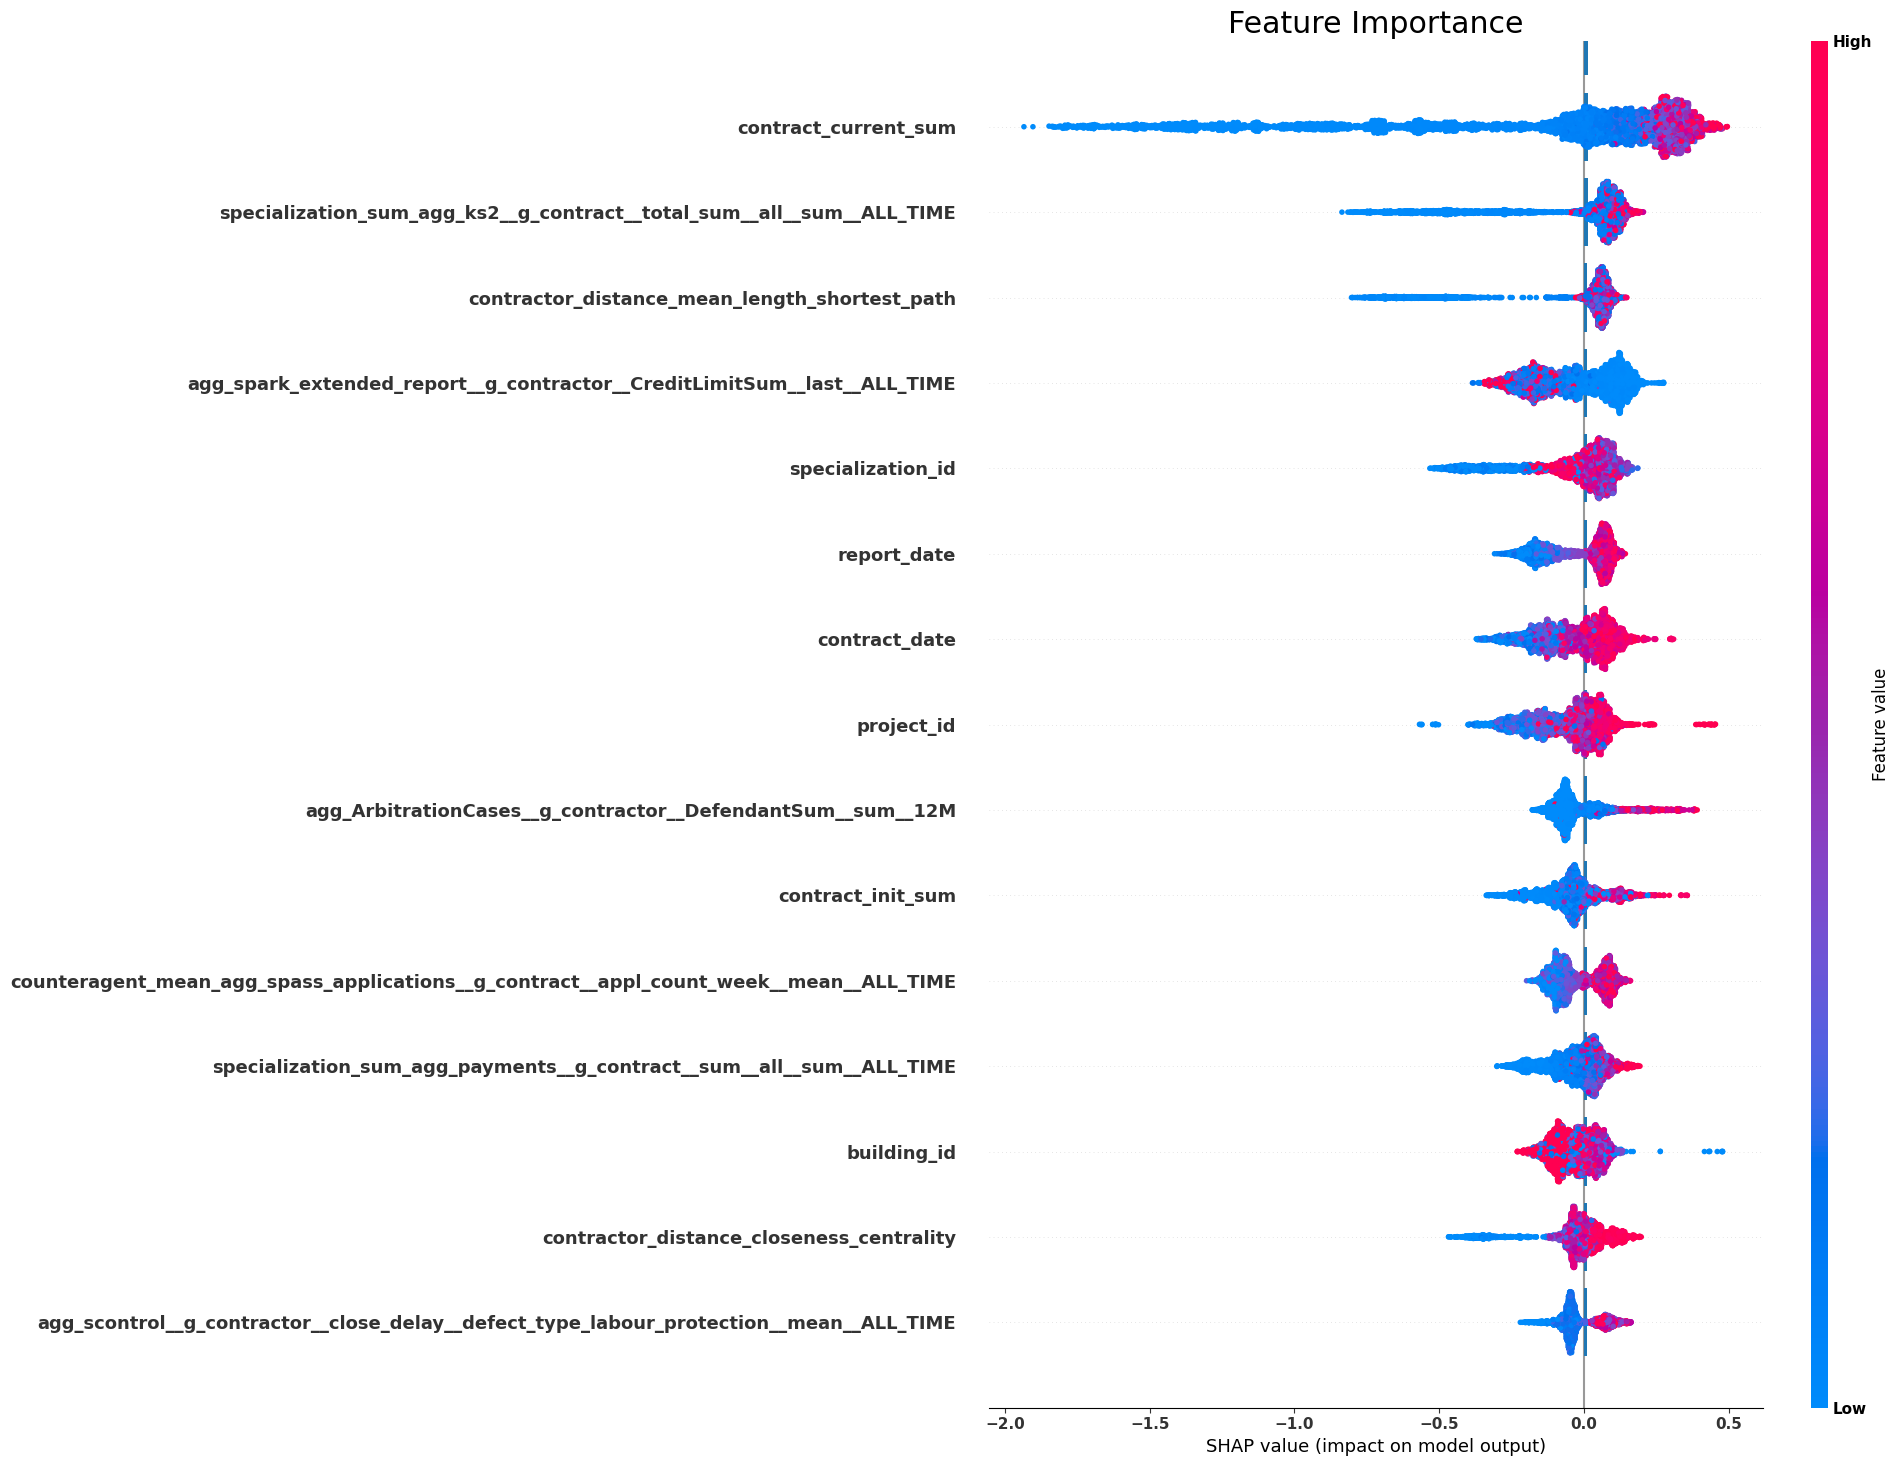

In [ ]:
def select_features_with_shap(model, data, k=100):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    def print_feature_importances_shap_values(shap_values, features, k, plot=False):

        importances = []
        for i in range(shap_values.values.shape[1]):
            importances.append(np.mean(np.abs(shap_values.values[:, i])))

        sorted_idx = np.argsort(importances)[-k:]
        features_k = features[sorted_idx]


        if plot:
            fig = plt.figure(figsize=(12, 6));
            plt.barh(range(len(features_k)), np.array(importances)[sorted_idx], align='center');
            plt.yticks(range(len(features_k)), features_k);
            plt.title('Feature Importance');

            shap.summary_plot(
                shap_values,
                feature_names=features,
                max_display=15,
                plot_size=(20, 15),
                show=False
            );

        return np.array(importances)[sorted_idx], features_k

    _, best_columns_shap = print_feature_importances_shap_values(
        shap_values,
        features=np.array(data.columns),
        k=k,
        plot=True
    )

    return best_columns_shap


# Номер фолда:
fold_num_to_analyze=4
best_features_shap = select_features_with_shap(worker.folds_models[fold_num_to_analyze], worker.folds[f"fold_{fold_num_to_analyze}"][1][0])

 **Model importance на всех фолдах**

Всего признаков 793 Усреднее по 5-ти моделям: 
На график нанесено топ-173 признаков


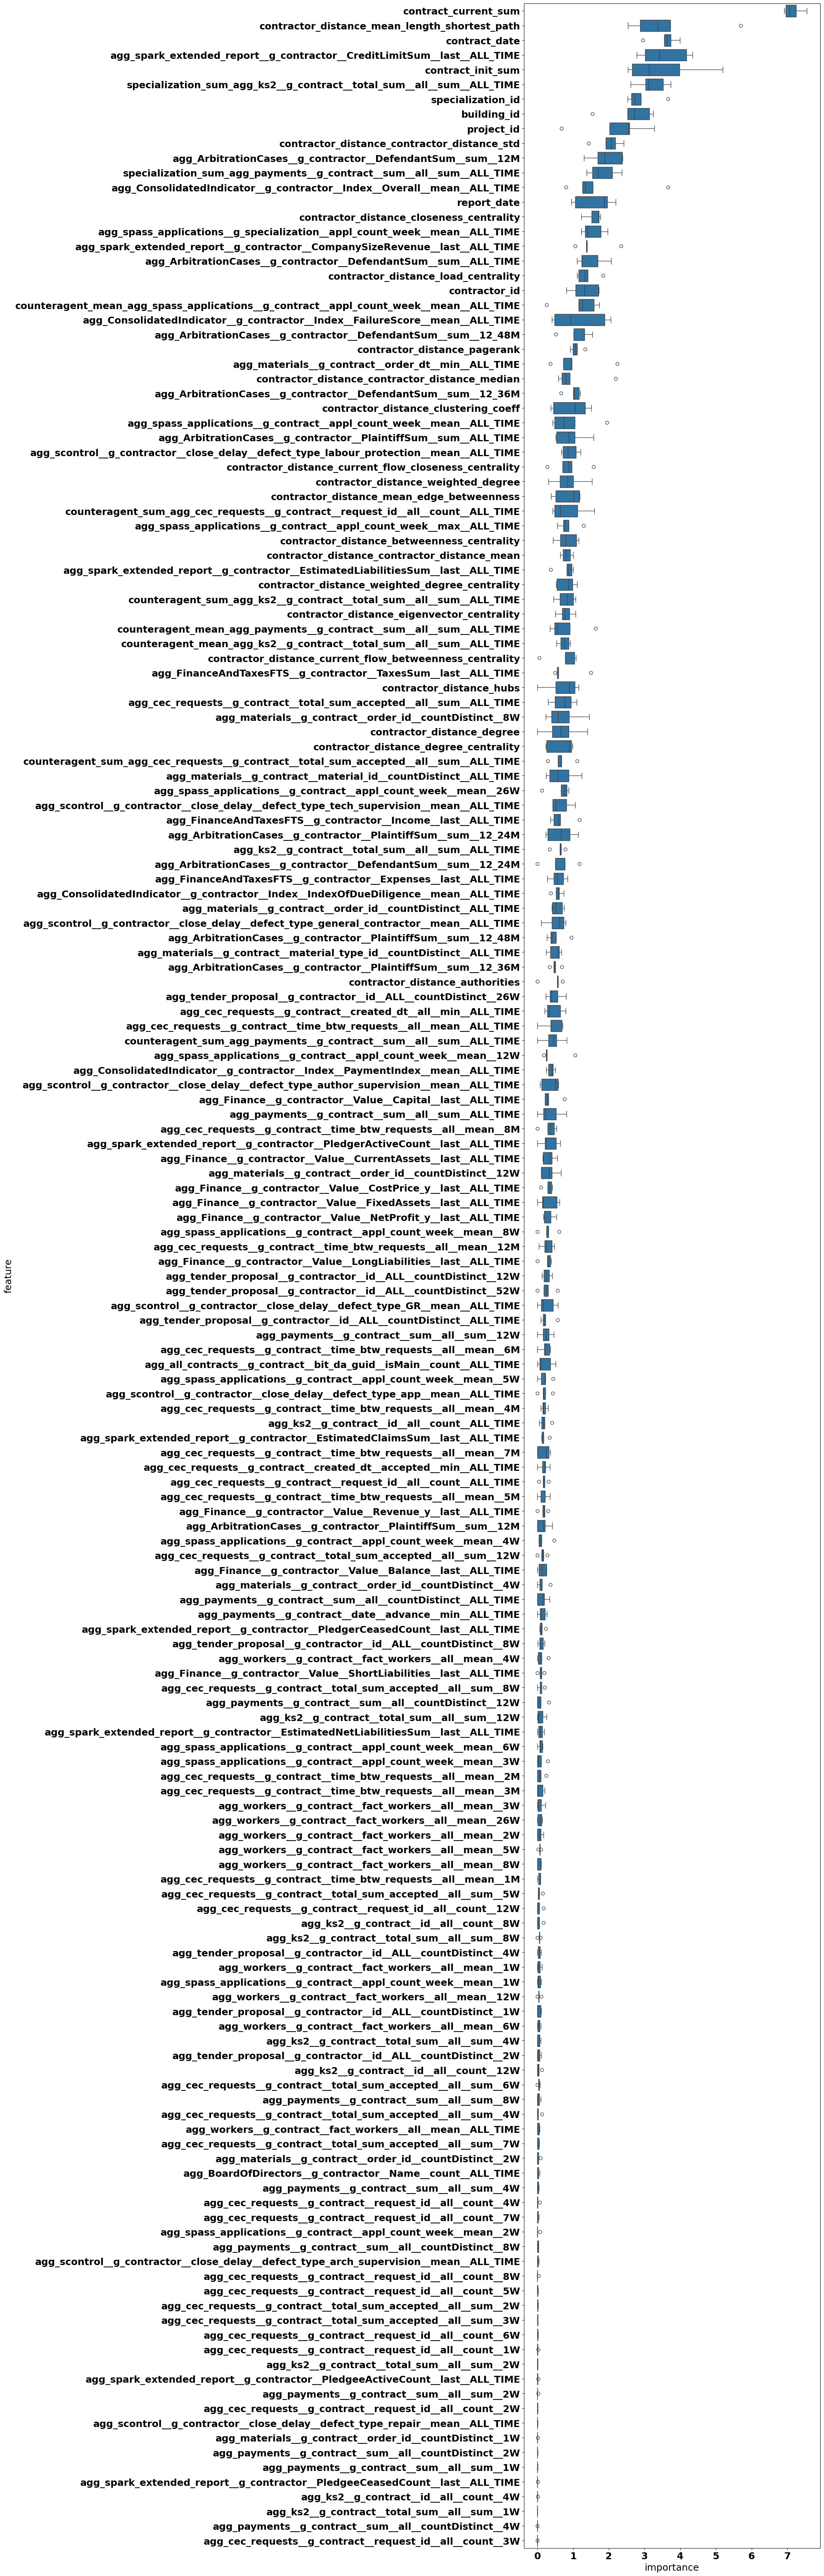

In [ ]:
def plot_importance(df, best_model, height, top_n=50):

    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]

    fi = fi[fi['feature'].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)

    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].median().sort_values(by='importance', ascending=False)


df_feats_imp = plot_importance(
  train.drop(
    columns=[contract_id_col, target_column]
    #  ["project_id", "building_id", "contractor_id"]
  ),
  worker.folds_models,
  height = 0.50,
  top_n = 173
)

In [ ]:
graph_features_columns = list(pd.read_csv("contractor_graph_features_v2.csv").columns) + list(pd.read_csv("contractor_graph_features_v3.csv").columns)

In [ ]:
pd.read_csv("contractor_graph_features_v2.csv").describe()

,contractor_id,contractor_distance_degree,contractor_distance_weighted_degree,contractor_distance_weighted_degree_centrality,contractor_distance_degree_centrality,contractor_distance_betweenness_centrality,contractor_distance_closeness_centrality,contractor_distance_eigenvector_centrality,contractor_distance_pagerank,contractor_distance_clustering_coeff,contractor_distance_eccentricity,contractor_distance_hubs,contractor_distance_authorities,contractor_distance_load_centrality,contractor_distance_current_flow_betweenness_centrality,contractor_distance_current_flow_closeness_centrality,contractor_distance_contractor_distance_mean,contractor_distance_contractor_distance_std,contractor_distance_contractor_distance_median
count,803.000000,803.000000,8.030000e+02,803.000000,803.000000,8.030000e+02,803.000000,803.000000,803.000000,803.000000,803.0,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000,803.000000
mean,451.731009,789.075965,5.185936e+05,0.019858,0.983885,2.011830e-05,0.003200,0.026801,0.001245,0.003457,2.0,0.001245,0.001245,0.000342,0.001427,170.622639,655.577588,3191.859124,350.684932
std,261.133611,3.586544,2.482499e+06,0.095059,0.004472,2.065594e-07,0.000301,0.022972,0.005458,0.009736,0.0,0.001067,0.001067,0.000534,0.012309,17.493976,3137.288030,488.975256,3253.839887
min,0.000000,780.000000,2.123520e+05,0.008131,0.972569,1.948974e-05,0.000031,0.019576,0.000590,0.001929,2.0,0.000910,0.000910,0.000000,0.000121,148.710271,305.097257,0.000000,17.000000
25%,225.000000,787.000000,2.517155e+05,0.009639,0.981297,2.002486e-05,0.003206,0.022887,0.000666,0.002345,2.0,0.001063,0.001063,0.000003,0.000186,163.029440,346.229426,3254.054382,20.000000
50%,454.000000,789.000000,2.788000e+05,0.010676,0.983791,2.014049e-05,0.003231,0.025427,0.000714,0.002479,2.0,0.001181,0.001181,0.000081,0.000199,171.684923,348.579800,3255.662290,24.000000
75%,679.500000,791.000000,2.827420e+05,0.010827,0.986284,2.023980e-05,0.003265,0.025463,0.000723,0.002640,2.0,0.001183,0.001183,0.000479,0.000216,172.876739,353.271820,3256.127290,28.000000
max,898.000000,798.000000,2.611530e+07,1.000000,0.995012,2.046056e-05,0.003283,0.262454,0.057577,0.104393,2.0,0.012195,0.012195,0.004176,0.126106,335.710561,32767.000000,13870.398388,32767.000000


In [ ]:
gb = train.groupby('contract_id')['default6'].agg(lambda x: 1 in list(x))

In [ ]:
gb1 = train.groupby('contract_id').size()

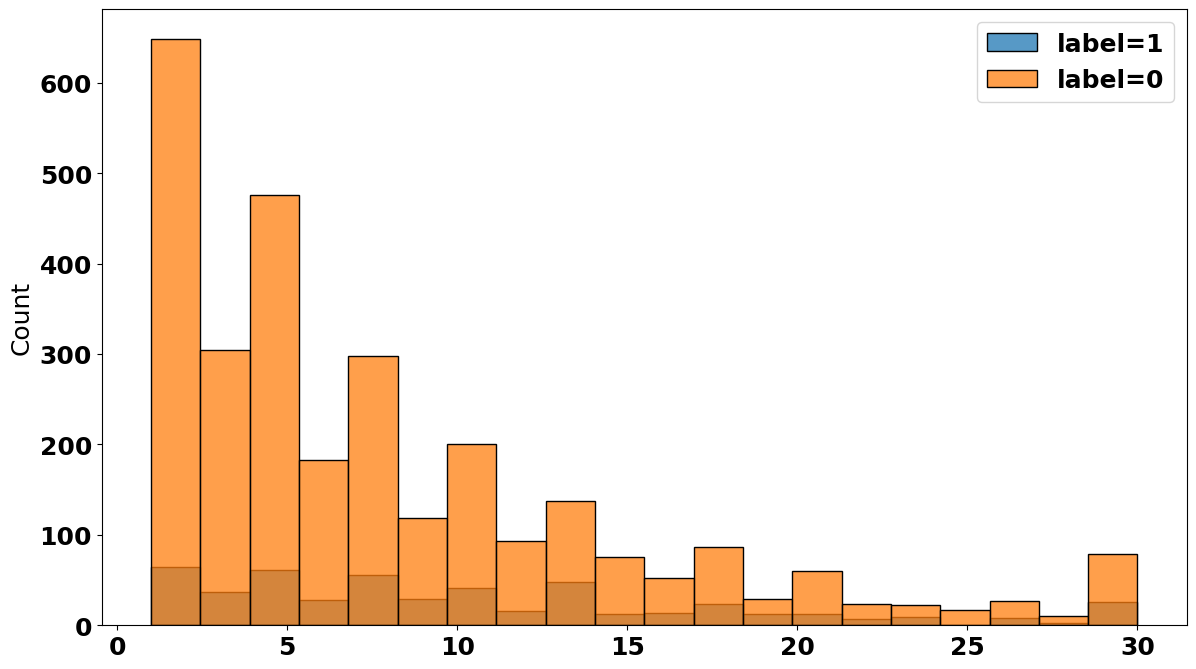

In [ ]:
sns.histplot(
    gb1.loc[gb[gb].index],
    bins=20,
    label='label=1'
)
sns.histplot(
    gb1.loc[gb[~gb].index],
    bins=20,
    label='label=0'
)
plt.legend()
plt.show()

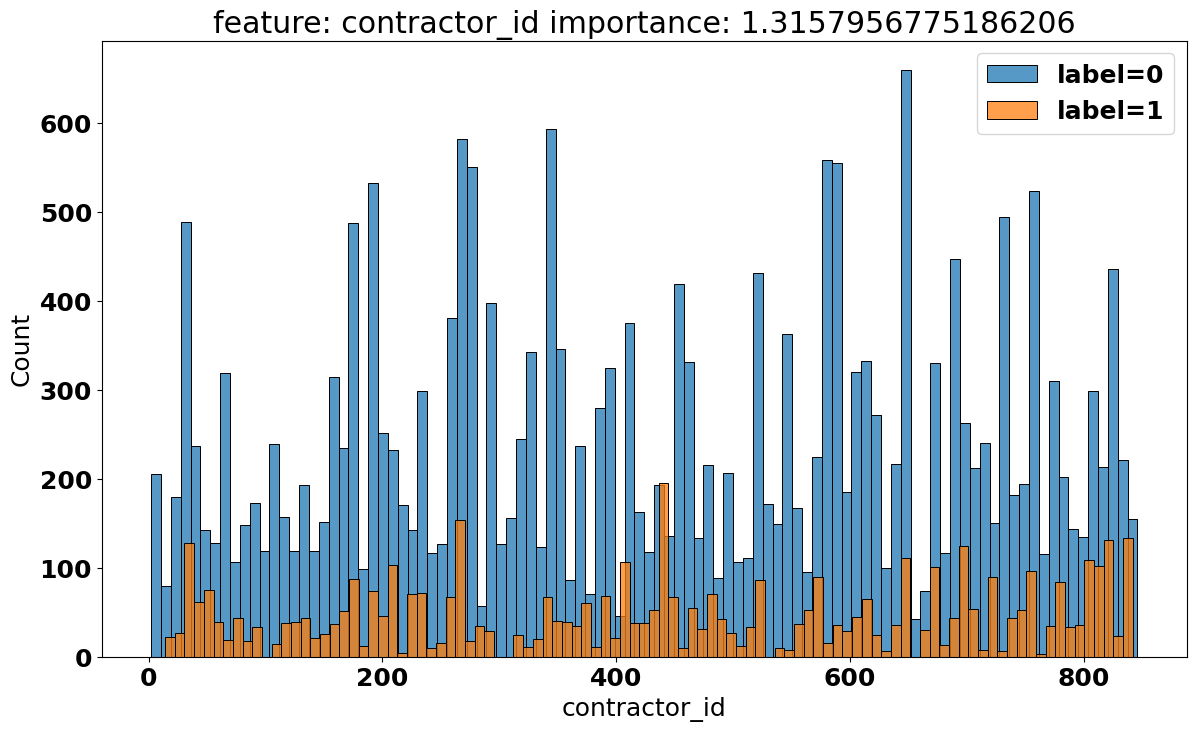

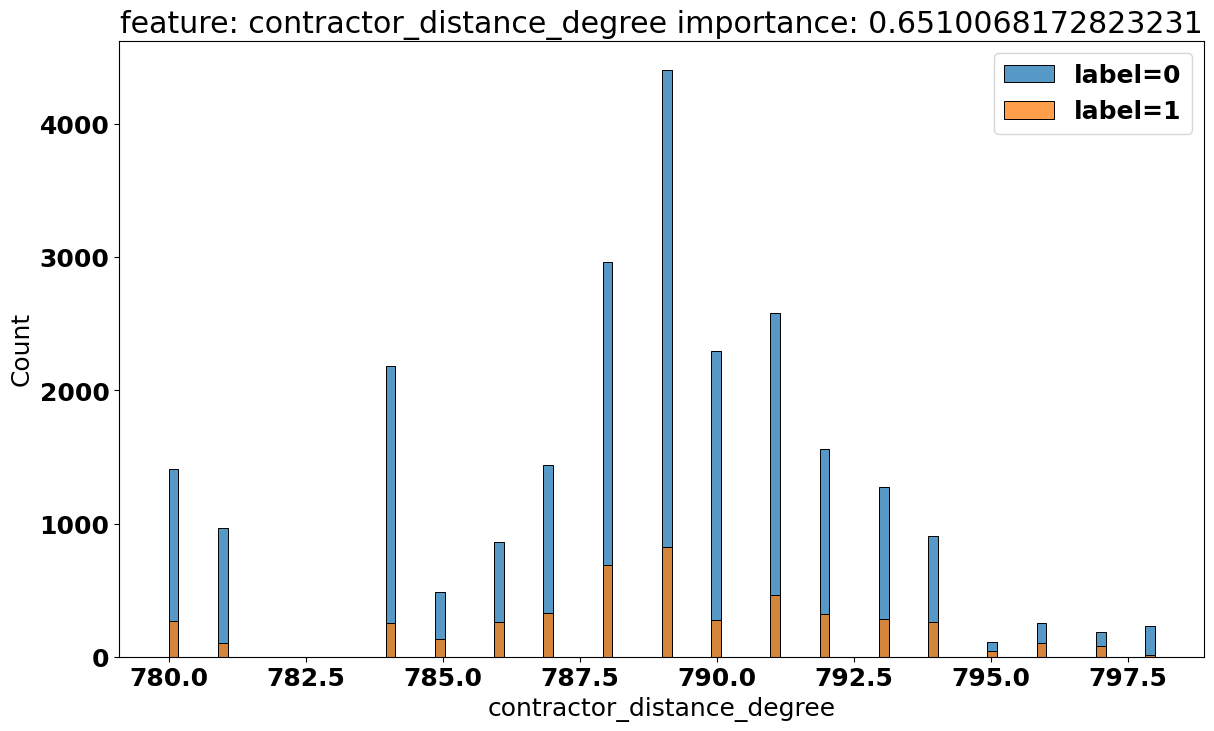

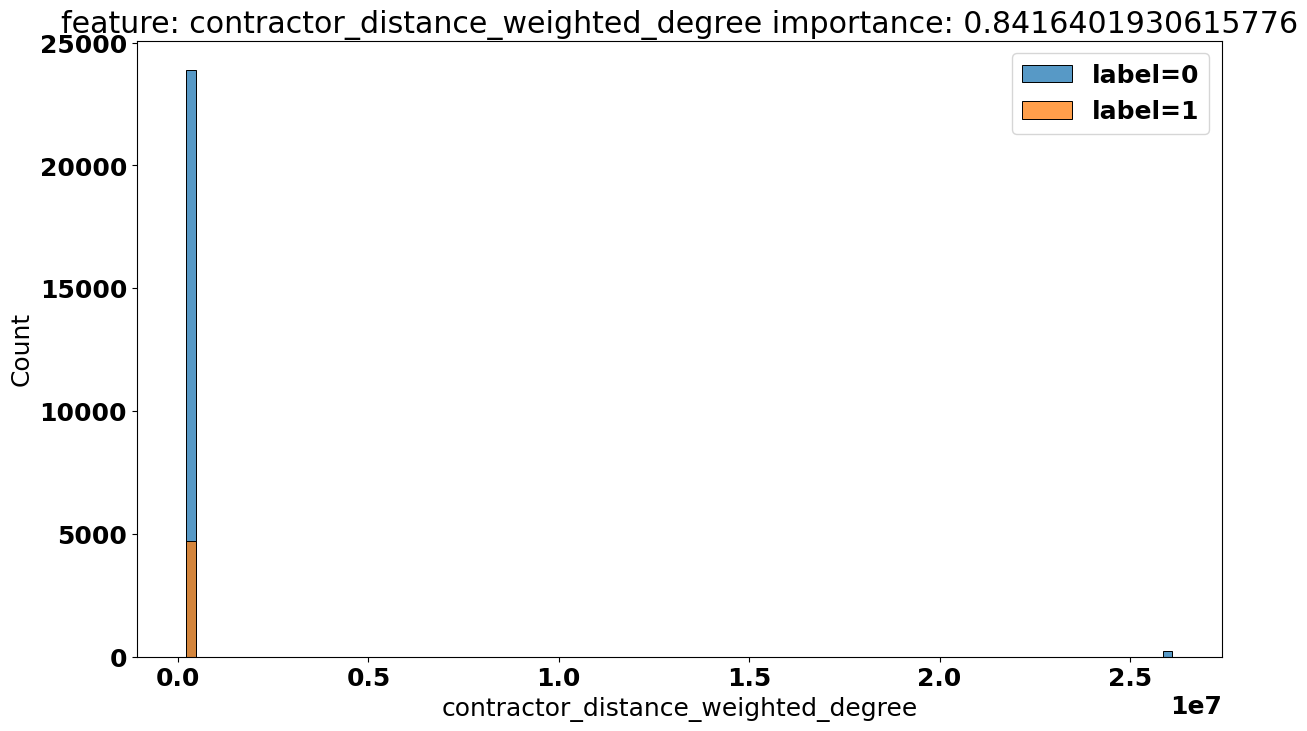

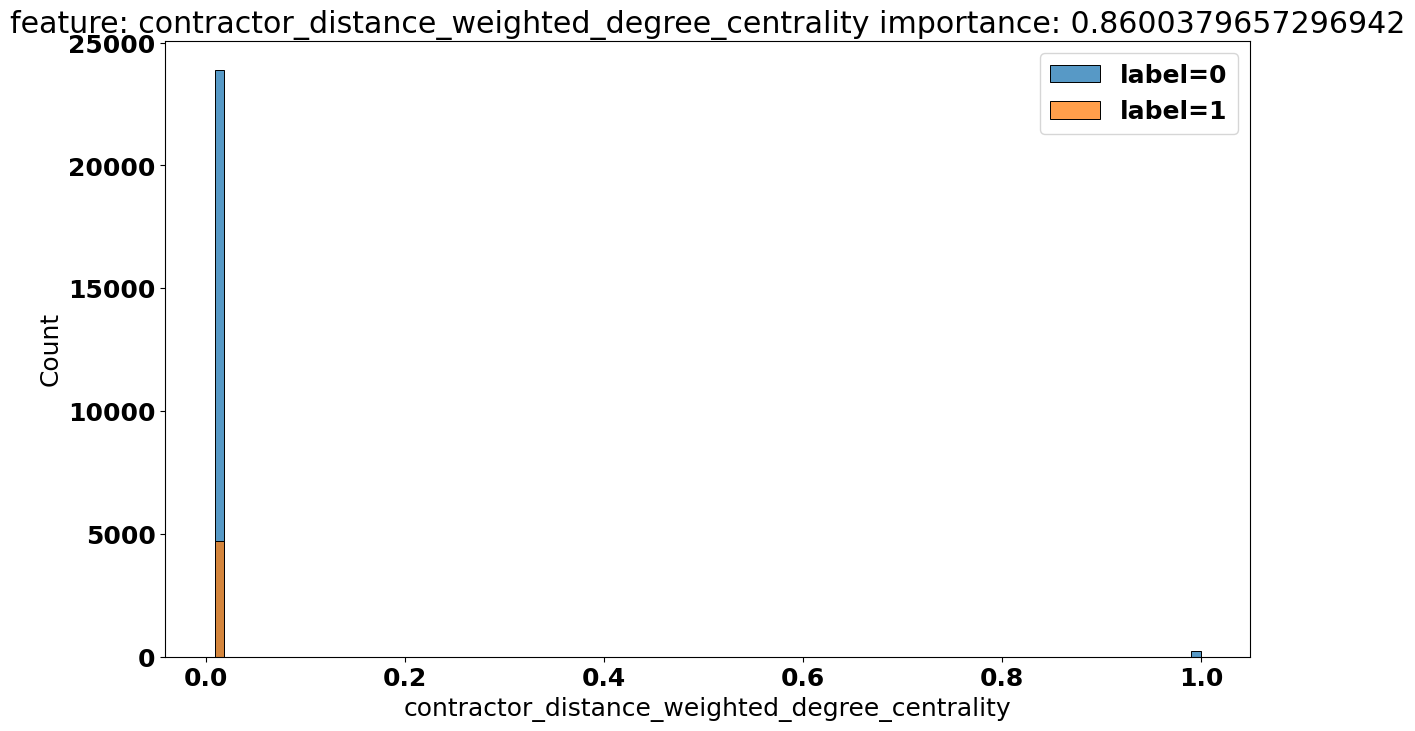

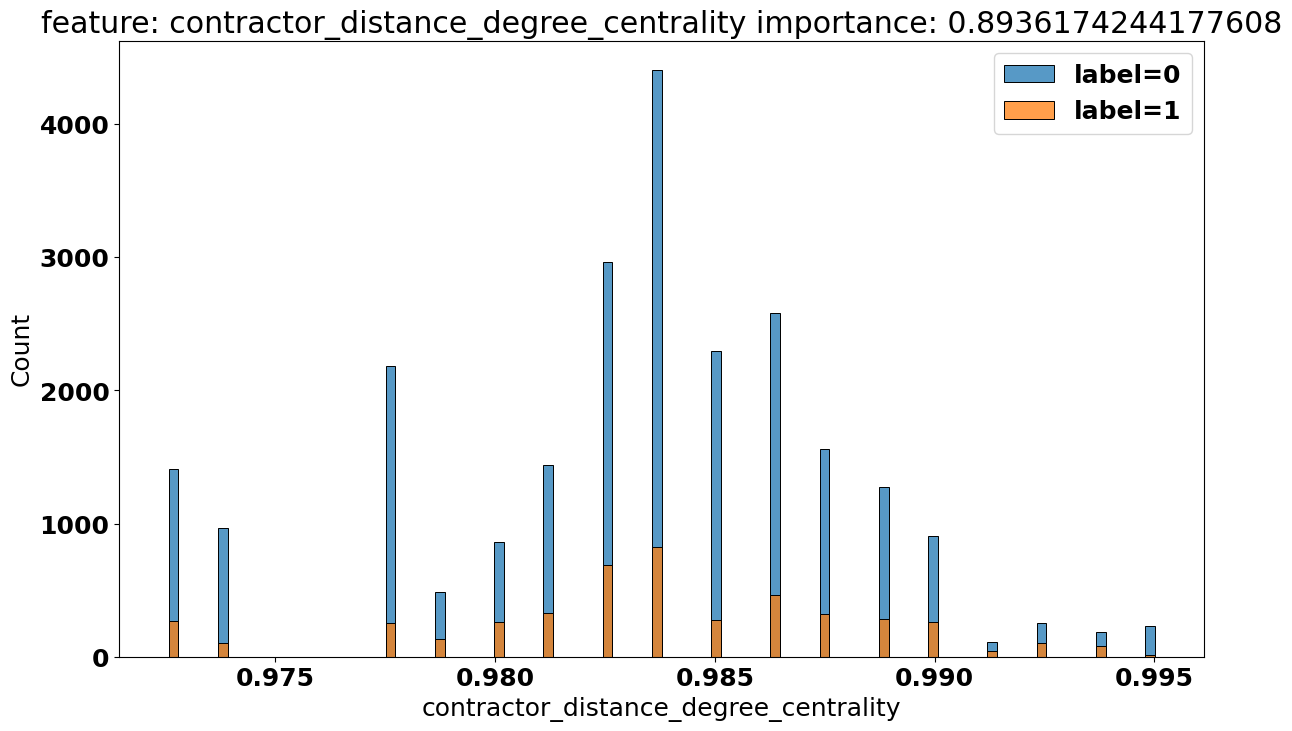

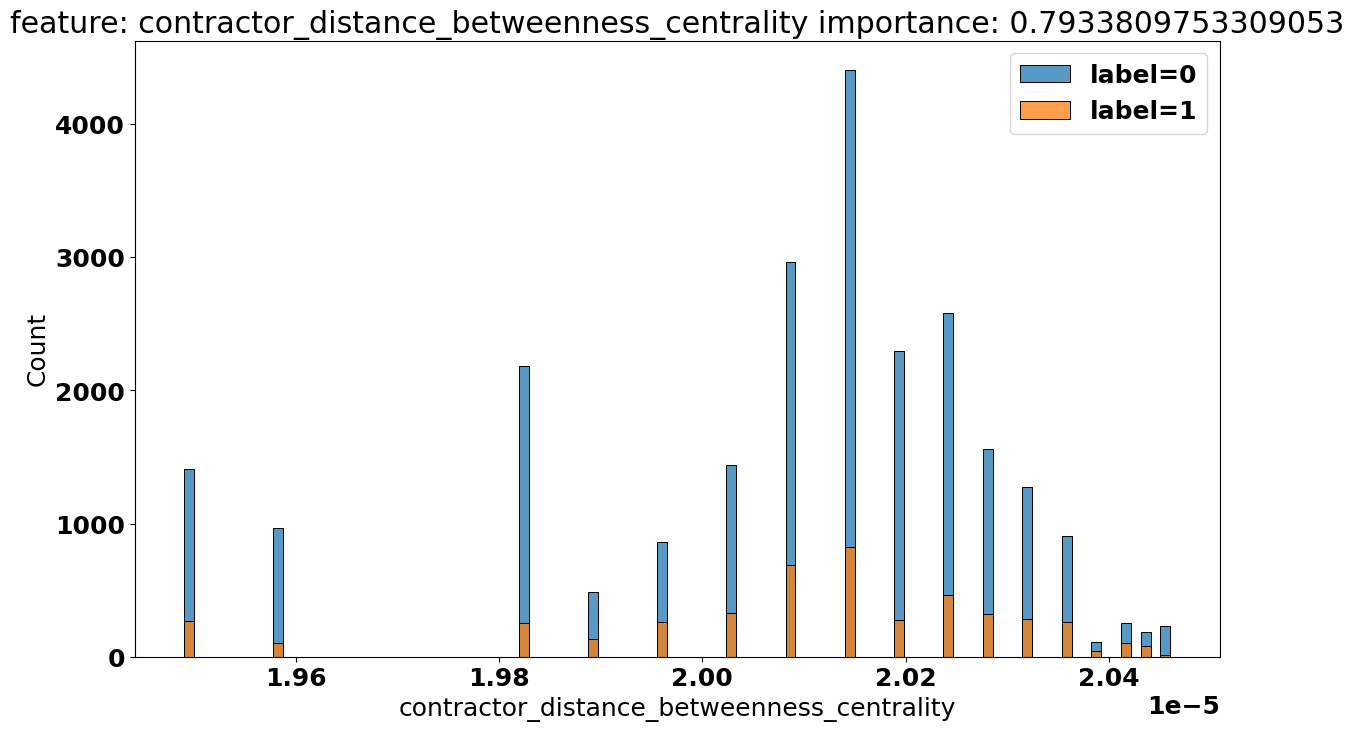

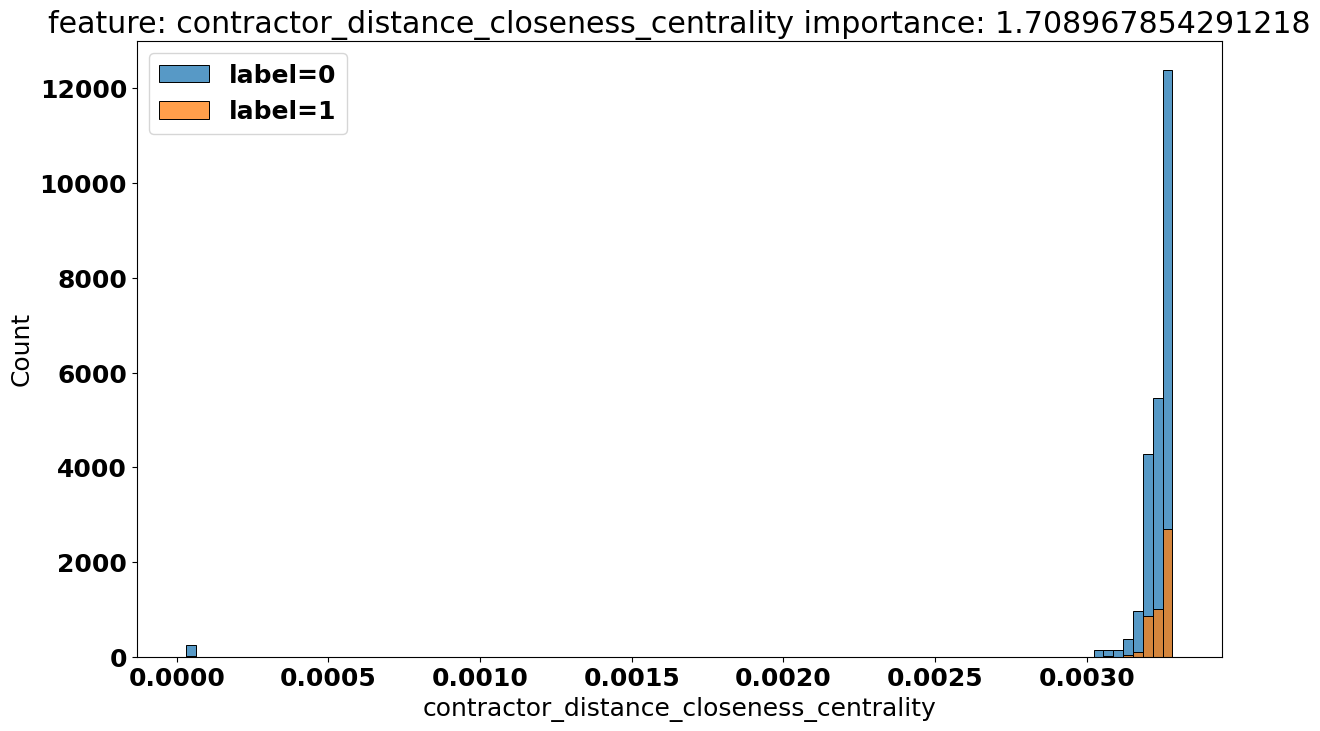

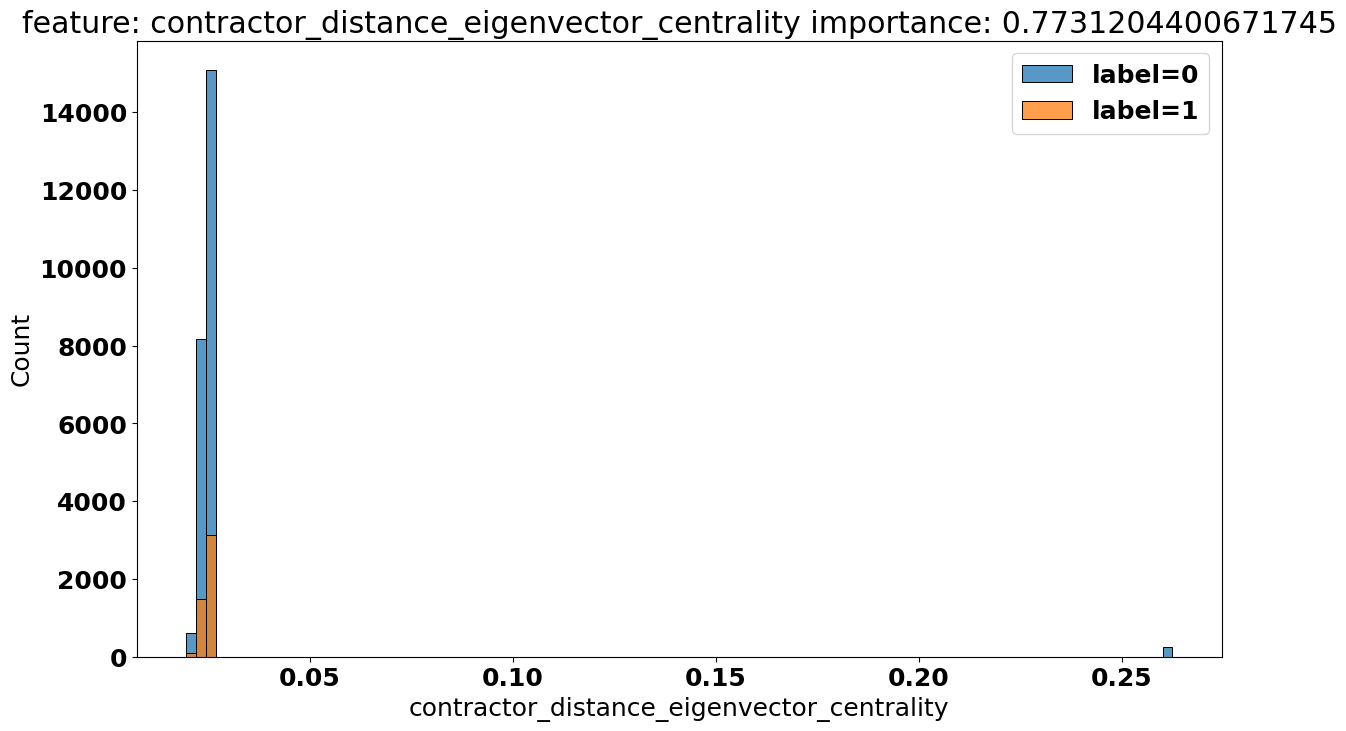

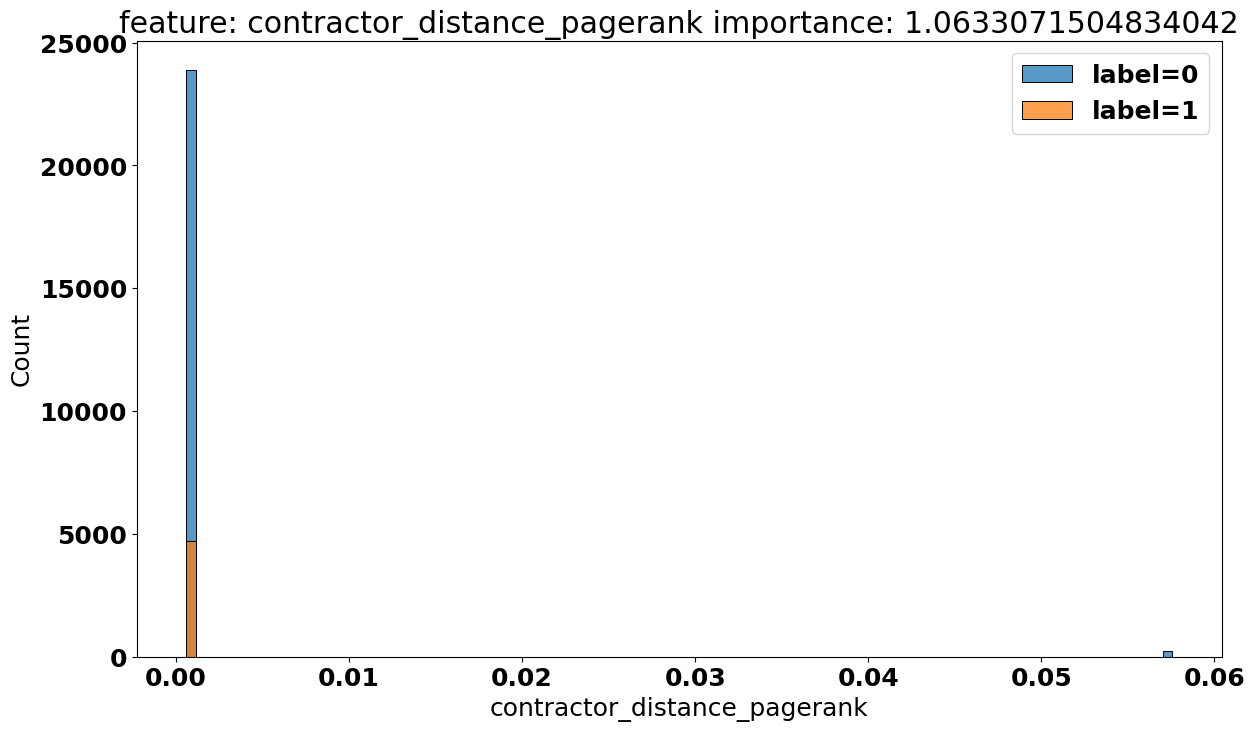

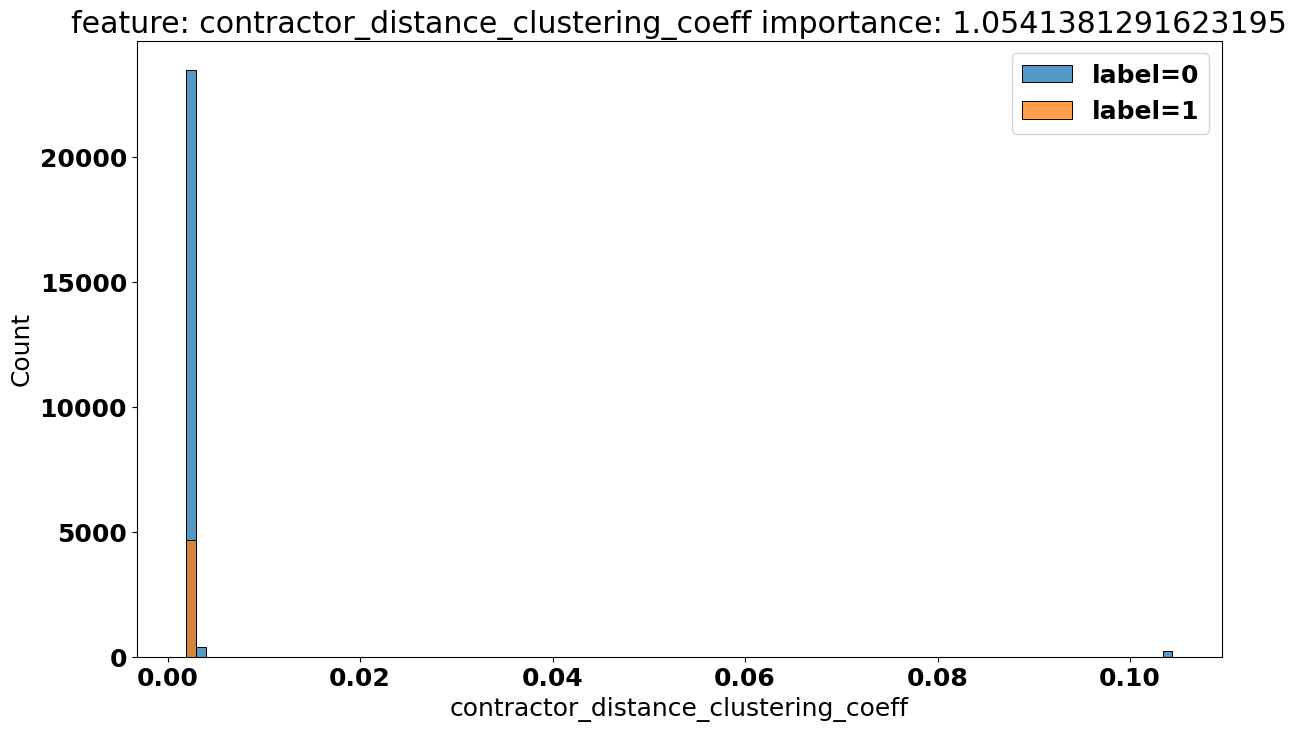

IndexError: index 0 is out of bounds for axis 0 with size 0

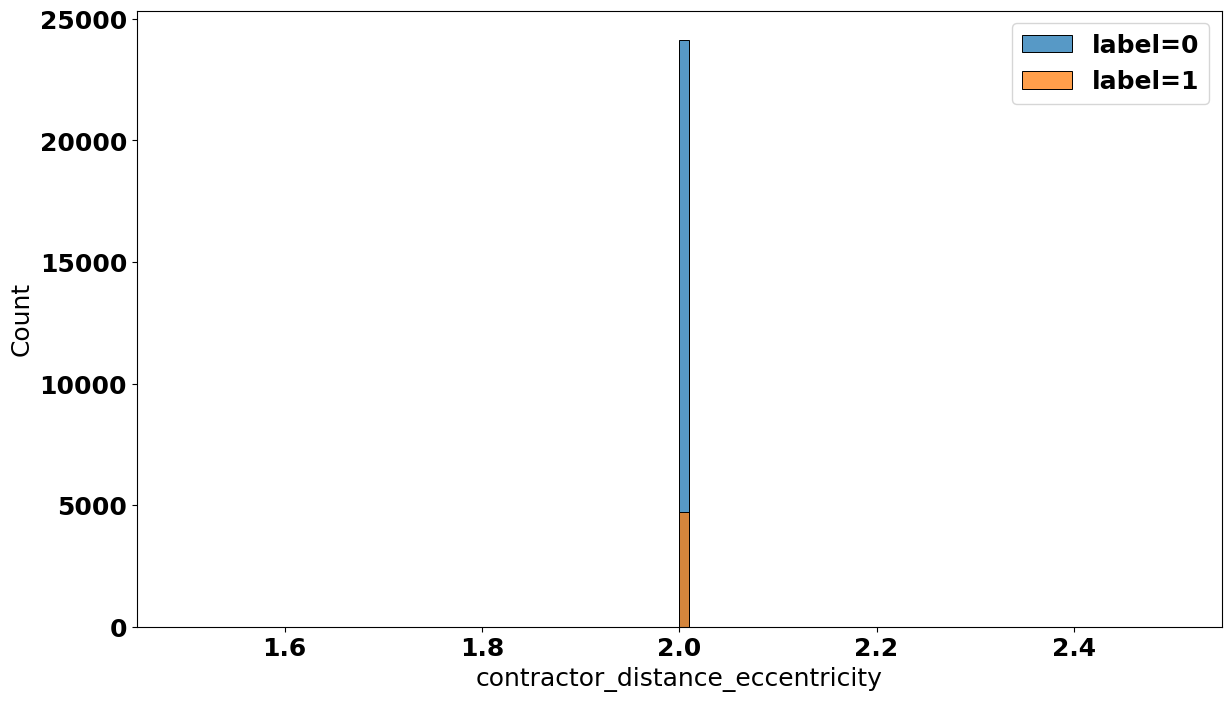

In [ ]:
for feat in graph_features_columns:
  sns.histplot(
      train[train.default6 == 0][feat],
      bins=100,
      label='label=0'
  )
  sns.histplot(
      train[train.default6 == 1][feat],
      bins=100,
      label='label=1'
  )
  plt.legend()
  plt.title(f'feature: {feat} importance: {df_feats_imp.loc[df_feats_imp["feature"] == feat, "importance"].values[0]}')
  plt.show()

## **Тюнинг гиперпараметров с помощью *Optuna***

In [ ]:
def tune_hyperparams(
    model, #cat_cols
    n_trials, cat_cols=None, save_weights=False, fixed_params=None
):

    if fixed_params is None:
        fixed_params = {}


    if model not in ["catboost", "xgboost", "lightgbm"]:
        print(f"Incorrect model {model}, valid are ['catboost', 'xgboost', 'lightgbm']")


    if model == "catboost":

        base_params =  {
            "n_estimators": 300,
            "verbose": 50,
            "early_stopping_rounds": 50,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            # "auto_class_weights" : "Balanced",
            "use_best_model": True,
        }

        if torch.cuda.is_available():
            task_type='GPU'
        else:
            print('GPU IS NOT AVAILABLE!')
            task_type='CPU'
        worker_optuna.device = task_type


        for i in base_params.keys():
            if i not in fixed_params:
                fixed_params[i]=base_params[i]

        def objective(
            trial, init_params=fixed_params
        ):
            params = {
                "learning_rate": trial.suggest_float(
                    "learning_rate", 0.005, 0.2, log=True
                ),
                "scale_pos_weight": trial.suggest_float(
                    "scale_pos_weight", 1, 7, log=True
                ),
                "subsample": trial.suggest_float(
                    "subsample", 0.4, 1, log=True
                ),
                "depth": trial.suggest_int("depth", 3, 10),
                "l2_leaf_reg": trial.suggest_float(
                    "l2_leaf_reg", 1e-1, 100.0, log=True
                ),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 100, 500),
                "random_strength": trial.suggest_float(
                    "random_strength", 1e-3, 10.0, log=True
                )

            }

            for i in init_params.keys():
                params[i]=init_params[i]

            worker_optuna.init_model_params(
                model_params=params
            )

            worker_optuna.train_kfold(
                eval_metric=sklearn.metrics.roc_auc_score
            )

            res_score = worker_optuna.cross_val_score

            return res_score

    study = optuna.create_study(direction="maximize")

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    print('='*30)
    trial = study.best_trial

    print("AUC: {}".format(trial.value))
    print('='*30)
    print("  Params: {")

    params = trial.params

    for i in fixed_params.keys():
            if i not in params:
                params[i]=fixed_params[i]

    for key, value in params.items():
        if isinstance(value, str):
            print("    '{}': '{}',".format(key, value))
        else:
            print("    '{}': {},".format(key, value))
    print('}')
    return params, trial.value

*Настроиваем класс для тюнинга и запускаем optuna*

In [ ]:
worker_optuna = CatBoostWorker(
    task='class',
    seed=1,
    device='CPU'
)

In [ ]:
groups_dict = {k : i for i, k in enumerate(cur_train[contract_id_col].unique())}

worker_optuna.split_folds(
    data=cur_train.drop(columns=[contract_id_col] + ["project_id", "building_id", "contractor_id"]),
    target_column=target_column,
    cv_type=("Group" if PIPELINE == 1 else "StratifiedGroup"),
    num_folds=5,
    test_size=0.0,
    extra_features_columns = {
        "cat_features" : ["specialization_id"]
    },
    verbose=True,
    groups=cur_train[contract_id_col].apply(lambda x: groups_dict[x]).tolist()
)

In [ ]:
tune_hyperparams("catboost", n_trials=100)

[I 2024-09-12 21:45:56,944] A new study created in memory with name: no-name-c273cc17-be96-4ef4-ac17-a7db95060fa9


GPU IS NOT AVAILABLE!


  0%|          | 0/100 [00:00<?, ?it/s]

0:	test: 0.6706466	test1: 0.6128314	best: 0.6128314 (0)	total: 109ms	remaining: 32.6s
50:	test: 0.8955068	test1: 0.7087988	best: 0.7232199 (16)	total: 5.25s	remaining: 25.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7232198976
bestIteration = 16

Shrink model to first 17 iterations.
FOLD 0, VAL SCORE: 0.7232198976385023
0:	test: 0.6936023	test1: 0.6505394	best: 0.6505394 (0)	total: 105ms	remaining: 31.5s
50:	test: 0.8769137	test1: 0.7554237	best: 0.7554237 (50)	total: 4.87s	remaining: 23.8s
100:	test: 0.9314185	test1: 0.7665680	best: 0.7682637 (88)	total: 8.04s	remaining: 15.8s
150:	test: 0.9654544	test1: 0.7807003	best: 0.7807016 (140)	total: 10.3s	remaining: 10.1s
200:	test: 0.9818588	test1: 0.7760231	best: 0.7818307 (152)	total: 12.6s	remaining: 6.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7818307437
bestIteration = 152

Shrink model to first 153 iterations.
FOLD 1, VAL SCORE: 0.7818307436941716
0:	test: 0.6902084	test1: 0.62591

KeyboardInterrupt: 

## **Делаем submission**

In [ ]:
inference_worker = CatBoostWorker(
    task='class',
    seed=1,
    device='CPU'
)

PATH_TO_CHECKPOINTS = "/content/cat_chkps_1"

loaded_models = []
for model_path in sorted(glob.glob(f"{PATH_TO_CHECKPOINTS}/*")):
  print(model_path)
  model = catboost.CatBoostClassifier()
  model.load_model(model_path)
  loaded_models.append(model)

inference_worker.folds_models = loaded_models
# inference_worker.folds_scores = [0.8106139688830704,
#  0.7777813745766267,
#  0.7741517994582072,
#  0.7374233574796779,
#  0.7906015180531458]
inference_worker.folds_scores = worker_orig_folds_scores
# подставить веса

/content/cat_chkps_1/cat_with_features_0.cbm
/content/cat_chkps_1/cat_with_features_1.cbm
/content/cat_chkps_1/cat_with_features_2.cbm
/content/cat_chkps_1/cat_with_features_3.cbm
/content/cat_chkps_1/cat_with_features_4.cbm


*Получаем предсказания на каждом фолде и затем усредняем их с весами*

In [ ]:
test_pool = catboost.Pool(data=test.drop(columns=contract_id_col))

probs = inference_worker.inference_model(
    return_probs=True,
    use_kfold_models=True,
    test_pool=test_pool
)

w = inference_worker.folds_scores
# w = [0, 0, 1, 0, 0]
probs = (np.stack(probs) * np.array(w).reshape(-1, 1)).sum(axis=0) / np.sum(w)

*Смотрим на распределения вероятностей*

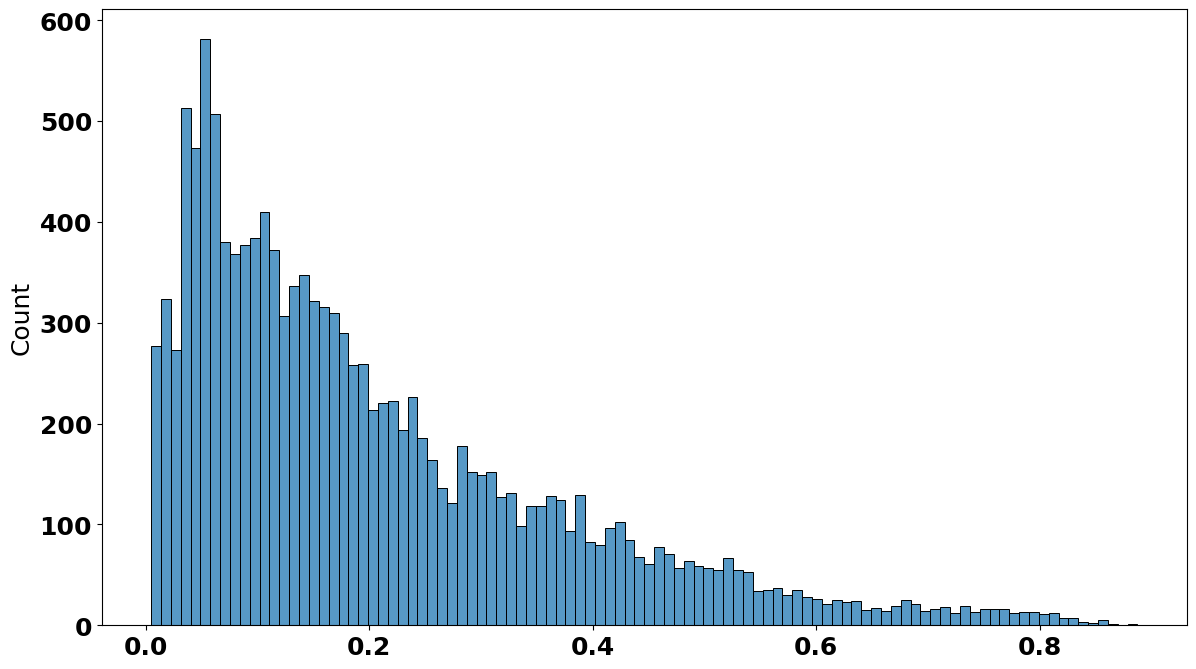

In [ ]:
sns.histplot(
    probs,
    bins=100
);

*Сохраняем результат*

In [ ]:
# подгружаем sample_submission если его не было
%%capture
if not os.path.exists("subs"):

  !gdown 1N8sk3QtRA8Y6gmXew9wz5Kmkim3ZUB9W
  %mkdir /content/subs

In [ ]:
# проверяем, что всё корректно подставилось
sample_submit = pd.read_csv('test2_X.csv')[['contract_id', 'report_date']]
sample_submit["score"] = probs
sample_submit.head(5)

,contract_id,report_date,score
0,3029,2023-07-30,0.107200
1,4350,2023-07-30,0.192169
2,1095,2023-07-30,0.090504
3,2634,2023-07-30,0.059026
4,6535,2023-07-30,0.082740


In [ ]:
# сохраняем результат
sub_name = "only_catboost_with_new_oversampling"
sample_submit.to_csv(f"subs/{sub_name}.csv", index=False)

**Готово! Сабмит лежит в папке /subs**

In [ ]:
sub1 = pd.read_csv("/content/only_catboost_oversampling1 (1).csv")
sub2 = pd.read_csv("/content/only_catboost_with_features (2).csv")

In [ ]:
sub1["score"] = (sub1["score"] * 0.44991862255712833 + sub2["score"] * 0.4565449262093422) / (0.4565449262093422 + 0.44991862255712833)

In [ ]:
sub1.to_csv("sub_blend_deter.csv", index=False)